In [1]:
# Import dependencies
from scipy.io import wavfile
from sklearn.svm import SVC
from scipy.signal import spectrogram
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from pathlib import Path

import glob
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import random
#assert tf.__version__ == "1.7.0"
#tf.logging.set_verbosity(tf.logging.INFO)


In [8]:
print(os.getcwd())
dataset = [{'path': path, 'label': path.split('/' )[4] } for path in glob.glob("../../dataset_heart_sound/AV/**/*.wav")]
df = pd.DataFrame.from_dict(dataset)
print(dataset[0])

# Add a column to store the data read from each wavfile...   
df['x'] = df['path'].apply(lambda x: wavfile.read(x)[1])
df.head()

/workspaces/Creative_factory_bit_2022/CNN_demo/Audio Classification ANN CNN Keras
{'path': '../../dataset_heart_sound/AV/abnormal/50066_AV.wav', 'label': 'abnormal'}


,path,label,x
0,../../dataset_heart_sound/AV/abnormal/50066_AV...,abnormal,"[513, 349, 64, -77, 140, 211, -57, -206, -177,..."
1,../../dataset_heart_sound/AV/abnormal/2530_AV.wav,abnormal,"[-425, 1045, 518, -674, -690, -588, -237, -276..."
2,../../dataset_heart_sound/AV/abnormal/50631_AV...,abnormal,"[-643, -222, 1664, 3281, 2403, 1601, 987, -623..."
3,../../dataset_heart_sound/AV/abnormal/85019_AV...,abnormal,"[331, 950, 528, -393, -207, -435, -1038, -1068..."
4,../../dataset_heart_sound/AV/abnormal/49561_AV...,abnormal,"[49, 44, -16, -38, 117, 102, -36, -27, 136, 35..."


# Sample class audio plot 

Displaying all three kinds of audio classes normal, abnormal and extrasystole. We can see different patters in various classes.


['/workspaces/python_env1/Creative_factory/the-circor-digiscope-phonocardiogram-dataset-1.0.3/AV/normal/85113_AV.wav']
['/workspaces/python_env1/Creative_factory/the-circor-digiscope-phonocardiogram-dataset-1.0.3/AV/abnormal/59536_AV.wav']


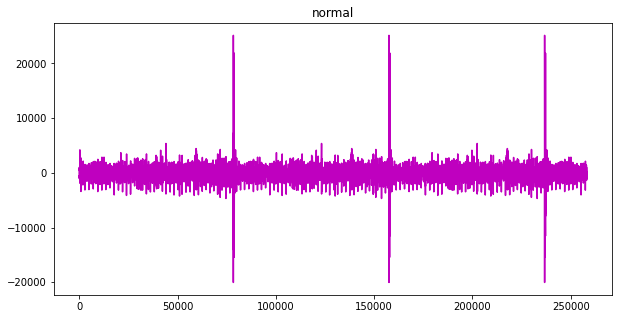

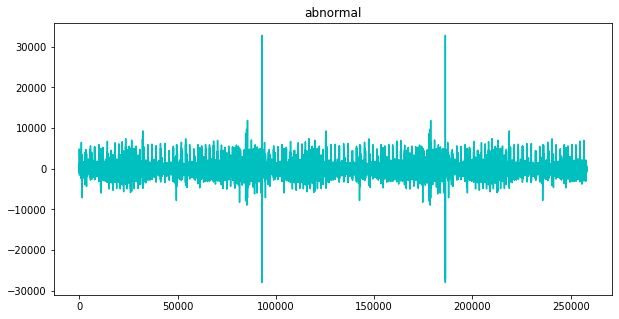

In [39]:
#Choosing one of the each samples form each catogery 
normal = df[df['label'] == 'normal' ].sample(1)
abnormal = df[df['label'] == 'abnormal' ].sample(1)
#extrasystole = df[df['label'] == 'extsys' ].sample(1)

# Plot the three samples onto three different figures
plt.figure(1, figsize=(10,5))
plt.title('normal')
plt.plot(normal['x'].values[0], c='m')
print(normal['path'].values)

plt.figure(2, figsize=(10, 5))
plt.title('abnormal')
plt.plot(abnormal['x'].values[0], c='c')
print(abnormal['path'].values)
#plt.figure(3, figsize=(10, 5))
#plt.title('extrasystole')
#plt.plot(extrasystole['x'].values[0], c='b')

In [27]:
#make the lenght of all audio files same by repeating audio file contents till its length is equal to max length audio file
max_length = max(df['x'].apply(len))

# Kaggle: What's in a heartbeat? - Peter Grenholm
def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = np.float32)
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

df['x'] = df['x'].apply(repeat_to_length, length=max_length)
df.head()

,path,label,x
0,/workspaces/python_env1/Creative_factory/the-c...,abnormal,"[513.0, 349.0, 64.0, -77.0, 140.0, 211.0, -57...."
1,/workspaces/python_env1/Creative_factory/the-c...,abnormal,"[-425.0, 1045.0, 518.0, -674.0, -690.0, -588.0..."
2,/workspaces/python_env1/Creative_factory/the-c...,abnormal,"[-643.0, -222.0, 1664.0, 3281.0, 2403.0, 1601...."
3,/workspaces/python_env1/Creative_factory/the-c...,abnormal,"[331.0, 950.0, 528.0, -393.0, -207.0, -435.0, ..."
4,/workspaces/python_env1/Creative_factory/the-c...,abnormal,"[49.0, 44.0, -16.0, -38.0, 117.0, 102.0, -36.0..."


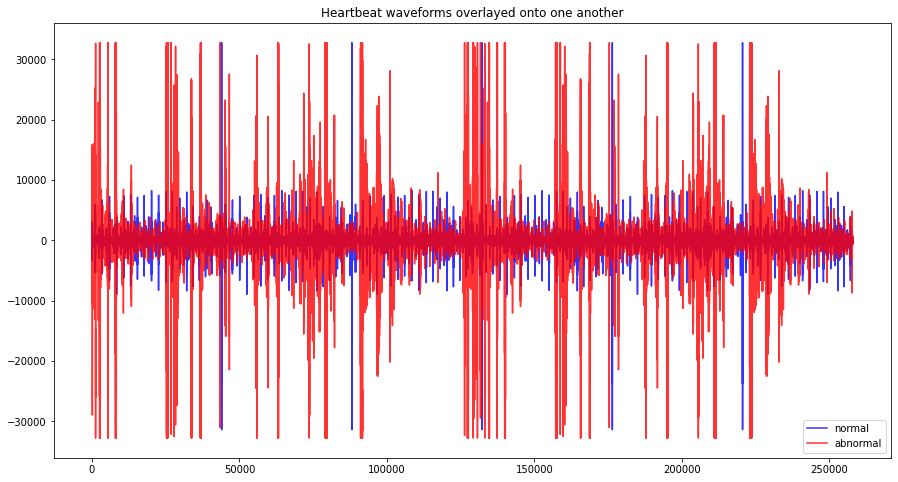

In [5]:
# Collect one sample from each of the three classes and plot their waveforms
normal = df[df['label'] == 'normal' ].sample(1)
abnormal = df[df['label'] == 'abnormal' ].sample(1)
#extrasystole = df[df['label'] == 'extsys' ].sample(1)

plt.figure(1, figsize=(15,8))
plt.plot(normal['x'].values[0], c='b', label='normal', alpha=0.8)
plt.plot(abnormal['x'].values[0], c='r', label='abnormal', alpha=0.8)
#plt.plot(extrasystole['x'].values[0], c='g', label='extrasystole', alpha=0.8)

plt.title('Heartbeat waveforms overlayed onto one another')
plt.legend(loc='lower right')
# plt.savefig('temp.png')

"\nf_extra, t_extra, Sxx_extra = spectrogram(extrasystole['x'].values[0], 4000)\nplt.figure(3, figsize=(20, 5))\nplt.title('Extrasystole')\nplt.pcolormesh(t_extra, f_extra, Sxx_extra, cmap='Spectral')\nplt.ylabel('Frequency [Hz]')\nplt.xlabel('Time [sec]')\n"

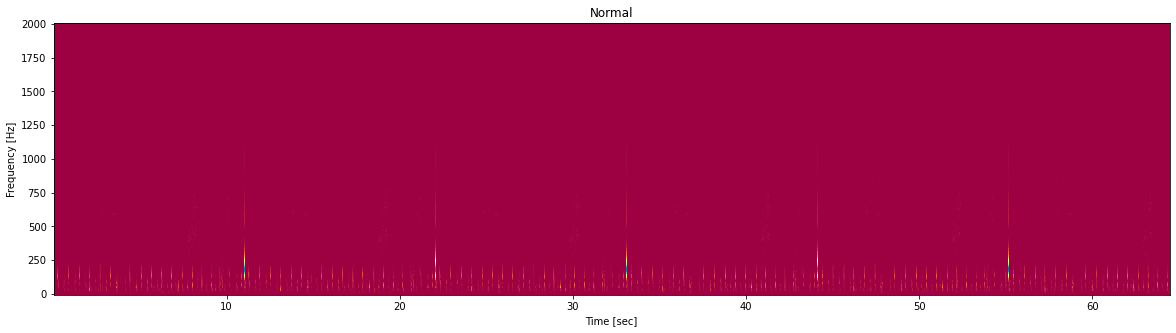

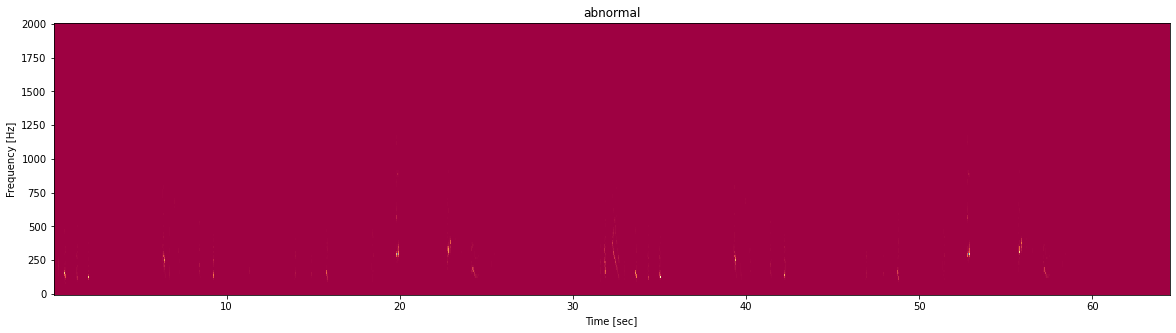

In [6]:
fs = 4000
f_normal, t_normal, Sxx_normal = spectrogram(normal['x'].values[0], 4000)
plt.figure(1, figsize=(20,5))
plt.title('Normal')
plt.pcolormesh(t_normal, f_normal, Sxx_normal, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

f_abnormal, t_abnormal, Sxx_abnormal = spectrogram(abnormal['x'].values[0], 4000)
plt.figure(2, figsize=(20, 5))
plt.title('abnormal')
plt.pcolormesh(t_abnormal, f_abnormal, Sxx_abnormal, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

"""
f_extra, t_extra, Sxx_extra = spectrogram(extrasystole['x'].values[0], 4000)
plt.figure(3, figsize=(20, 5))
plt.title('Extrasystole')
plt.pcolormesh(t_extra, f_extra, Sxx_extra, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
"""

In [7]:
# Put the data into numpy arrays. Most machine learning libraries use numpy arrays.
x = np.stack(df['x'].values, axis=0)
y = np.stack(df['label'].values, axis=0)

In [8]:
import librosa
import librosa.display

def calculate_melsp(x, n_fft=512, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft, n_mels=128)
    melsp = np.mean(melsp, axis=2)
    return melsp

In [9]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test, train_filenames, test_filenames = train_test_split(x, df['label'].values, df['path'].values, train_size = 0.7, test_size=0.3)
print("x_train: {0}, x_test: {1}".format(x_train.shape, x_test.shape))

#x_train = x_train[:, 40000:90000]

#x_test = x_test[:, 40000:90000]

x_train = calculate_melsp(x_train)
x_test = calculate_melsp(x_test)

print("x_train: {0}, x_test: {1}".format(x_train.shape, x_test.shape))

x_train: (550, 258048), x_test: (237, 258048)
x_train: (550, 128), x_test: (237, 128)


In [10]:
clf = SVC()


In [11]:
clf.fit(x_train, y_train)


SVC()

In [12]:
predictions = clf.predict(x_test)
print("Accuracy %.3f" % accuracy_score(y_test, predictions))

Accuracy 0.612


In [13]:
#clf = MLPClassifier(hidden_layer_sizes=(1024,512,256,128,), max_iter=5000, verbose=True)
clf = MLPClassifier(hidden_layer_sizes=(2000,1000,500,250,), 
                    max_iter=5000, verbose=True)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print("Accuracy %.3f" % accuracy_score(y_test, predictions))

Iteration 1, loss = 1.39798749
Iteration 2, loss = 0.79276710
Iteration 3, loss = 0.70226977
Iteration 4, loss = 0.69504661
Iteration 5, loss = 0.70485591
Iteration 6, loss = 0.69499478
Iteration 7, loss = 0.69370308
Iteration 8, loss = 0.69594369
Iteration 9, loss = 0.69527228
Iteration 10, loss = 0.69535067
Iteration 11, loss = 0.69445051
Iteration 12, loss = 0.69935133
Iteration 13, loss = 0.70156346
Iteration 14, loss = 0.70589194
Iteration 15, loss = 0.69297975
Iteration 16, loss = 0.69740441
Iteration 17, loss = 0.69332094
Iteration 18, loss = 0.69606091
Iteration 19, loss = 0.69193787
Iteration 20, loss = 0.69204476
Iteration 21, loss = 0.69213546
Iteration 22, loss = 0.69406121
Iteration 23, loss = 0.69067168
Iteration 24, loss = 0.69521833
Iteration 25, loss = 0.69083911
Iteration 26, loss = 0.69470678
Iteration 27, loss = 0.69415810
Iteration 28, loss = 0.69383149
Iteration 29, loss = 0.69352293
Iteration 30, loss = 0.69259949
Iteration 31, loss = 0.69251787
Iteration 32, los

In [14]:
# Convert data to the format tf.keras expects
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]
x_train.shape

(550, 128, 1)

# CNN Model

In [15]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=4, activation='relu',
                input_shape = x_train.shape[1:]))
model.add(tf.keras.layers.MaxPool1D(strides=2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=4, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=4, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.6))
#model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
#model.add(tf.keras.layers.MaxPool1D(strides=2))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.GlobalAvgPool1D())
model.add(tf.keras.layers.Dense(2, activation='softmax'))

2022-08-12 09:45:18.145091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 09:45:18.150248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 09:45:18.150545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 09:45:18.151036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [17]:
# Need to convert y labels into one-hot encoded vectors
y_train_int_categories, y_train_class_names = pd.factorize(y_train)
print("y_train_class_names: {0}".format(y_train_class_names))

y_test_int_categories, y_test_class_names = pd.factorize(y_test)
print("y_test_class_names: {0}".format(y_test_class_names))
y_train_hot = tf.keras.utils.to_categorical(y_train_int_categories)
y_test_hot = tf.keras.utils.to_categorical(y_test_int_categories)

hist = model.fit(x_train, y_train_hot, 
                epochs=300,
                validation_data=(x_test, y_test_hot), verbose=1)

y_train_class_names: ['normal' 'abnormal']
y_test_class_names: ['normal' 'abnormal']
Epoch 1/300


2022-08-12 09:45:20.268880: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


18/18 [==============================] - 3s 23ms/step - loss: 1.4006 - accuracy: 0.4927 - val_loss: 0.6939 - val_accuracy: 0.4895
Epoch 2/300
18/18 [==============================] - 0s 7ms/step - loss: 1.0493 - accuracy: 0.5564 - val_loss: 0.6961 - val_accuracy: 0.4895
Epoch 3/300
18/18 [==============================] - 0s 9ms/step - loss: 1.1438 - accuracy: 0.5509 - val_loss: 0.7016 - val_accuracy: 0.4895
Epoch 4/300
18/18 [==============================] - 0s 14ms/step - loss: 1.1148 - accuracy: 0.5309 - val_loss: 0.7198 - val_accuracy: 0.4895
Epoch 5/300
18/18 [==============================] - 0s 9ms/step - loss: 1.0367 - accuracy: 0.5345 - val_loss: 0.7151 - val_accuracy: 0.4895
Epoch 6/300
18/18 [==============================] - 0s 15ms/step - loss: 0.9776 - accuracy: 0.5545 - val_loss: 0.7343 - val_accuracy: 0.4895
Epoch 7/300
18/18 [==============================] - 0s 12ms/step - loss: 1.0044 - accuracy: 0.5182 - val_loss: 0.7944 - val_accuracy: 0.4895
Epoch 8/300
18/18 [==

# Plot of accuracy and loss

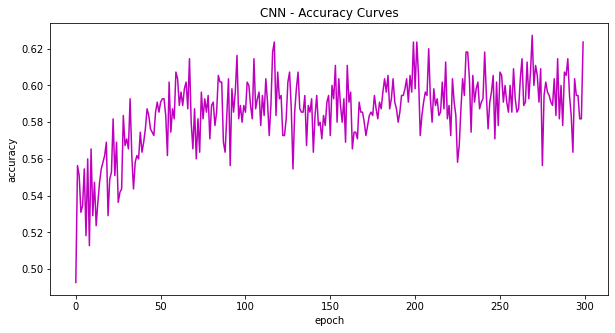

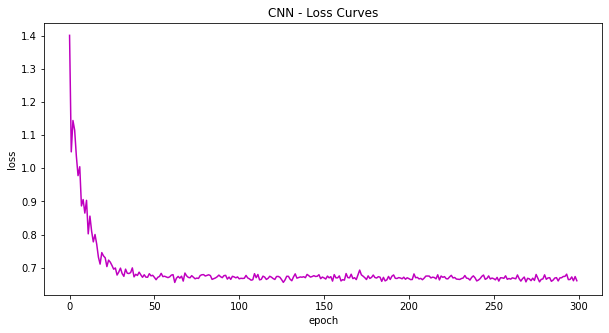

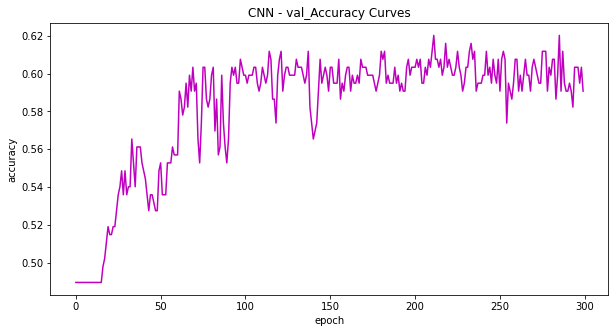

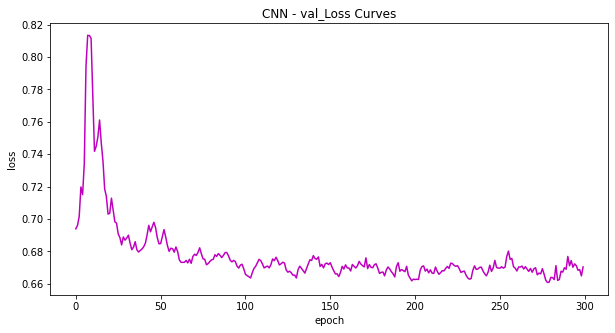

In [18]:
#print(hist.history)
accuracy = hist.history['accuracy']
loss = hist.history['loss']
val_accuracy = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

plt.figure(1, figsize=(10, 5))
plt.title('CNN - Accuracy Curves')
plt.plot(accuracy, c='m')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.figure(2, figsize=(10, 5))
plt.title('CNN - Loss Curves')
plt.plot(loss, c='m')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure(3, figsize=(10, 5))
plt.title('CNN - val_Accuracy Curves')
plt.plot(val_accuracy, c='m')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.figure(4, figsize=(10, 5))
plt.title('CNN - val_Loss Curves')
plt.plot(val_loss, c='m')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()


In [19]:
import time
start = time.time()*1000
model.predict(x_test)
end = time.time()*1000
total = end - start
print("Total prediction time (milliseconds) for %d samples: %f" % (len(x_test), total))
print("Average prediction time for one example: %f" % (total/len(x_test)))

8/8 [==============================] - 0s 2ms/step
Total prediction time (milliseconds) for 237 samples: 192.842285
Average prediction time for one example: 0.813681


In [20]:
# Save the train model
tf.keras.models.save_model(
    model,
    filepath='C:/Users/apt/Desktop/save_model',
    overwrite=True,
    include_optimizer=True
)

INFO:tensorflow:Assets written to: C:/Users/apt/Desktop/save_model/assets


INFO:tensorflow:Assets written to: C:/Users/apt/Desktop/save_model/assets
